In [3]:
import sys, os

# Add project root so that `src` package is discoverable
project_root = os.path.abspath(os.path.join("..", ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [28]:
from src.enums.PathEnums import Paths
from pathlib import Path
import pickle
import random

In [ ]:
def load_pkl():

    project_root = os.path.abspath(os.path.join("..", ".."))
    file_path = os.path.join(project_root, "datapkl", "annot_all.pkl")

    with open(file_path, "rb") as file:
        videos_annot = pickle.load(file)
    return videos_annot
# videos_annot_dct = load_pkl()
# print(len(videos_annot_dct))

In [50]:
with open(os.path.join('../..', Paths.ANNOT_PKL.value), "rb") as f:
            videos_annot_dct = pickle.load(f)
labels = set()
data_annot = []
for video_id, clips in videos_annot_dct.items(): # each video

    for clip_id, clip_data in clips.items():     # each clip

        category = clip_data['category']
        labels.add(category)

        for frame_id, boxes in clip_data["frame_boxes_dct"].items():    # Frames
            frame_path = f"{Paths.VIDEOS_ROOT.value}/{video_id}/{clip_id}/{frame_id}.jpg"
            data_annot.append(
                {
                    "path": frame_path, 
                    "category": category
                }
            )

In [51]:
for frame_dct in data_annot:
    for path, cat in frame_dct.items():
        print(frame_dct["path"], "==>", frame_dct["category"])
        break
    break

data/volleyball/volleyball_/videos/0/13286/13281.jpg ==> r_set


In [52]:
len_dataset = len(data_annot)
len_dataset, int(len_dataset*0.6), int(len_dataset*0.3), int(len_dataset*0.1)

(43470, 26082, 13041, 4347)

In [53]:
int(len_dataset*0.6) +  int(len_dataset*0.3) + int(len_dataset*0.1)

43470

In [32]:
train_ratio, valid_ratio=0.6,0.1
random.shuffle(data_annot)
n_total = len(data_annot)
n_train = int(train_ratio * n_total)
n_valid = int(valid_ratio * n_total)
# print("split", n_total, n_train, n_valid, n_total-n_train-n_valid)
# 4370 || 26082 || 13041 || 4347
train_split  = data_annot[:n_train]
valid_split  = data_annot[n_train:n_train+n_valid]
test_split   = data_annot[n_train+n_valid:]

len(data_annot), len(train_split), len(valid_split), len(test_split)  # (43470, 26082, 4347, 13041)


(43470, 26082, 4347, 13041)

In [56]:
train_split[0]

{'path': 'data/volleyball/volleyball_/videos/25/39235/39230.jpg',
 'category': 'l-spike'}

In [58]:
for item in train_split:
    print(item["path"])
    print(item["category"])
    break
train_split[0]["path"]

data/volleyball/volleyball_/videos/25/39235/39230.jpg
l-spike


'data/volleyball/volleyball_/videos/25/39235/39230.jpg'

In [60]:
path = Path(train_split[0]["path"])
vid_num = path.parents[1].name
s = os.path.basename(path)
print(vid_num, s)

25 39230.jpg


In [62]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [67]:
print(type(train_split))  
# <class 'list'>

print(type(train_split[0]))  
# <class 'dict'>

<class 'list'>
<class 'dict'>


In [68]:
categories = set([item["category"] for item in train_split])
print(categories)

{'l-spike', 'r-pass', 'l_winpoint', 'l-pass', 'r_spike', 'r_winpoint', 'l_set', 'r_set'}


In [71]:
def get_list_of_files(data_split):
    paths = [item["path"] for item in data_split]
    return paths
print(len(get_list_of_files(train_split)))


26082


In [74]:

def plot_random_image_from_dir(data):
    """Prints a random image from dir_path."""

    

    image_path_list = get_list_of_files(data)
    random_image_path = random.choice(image_path_list)
    img = Image.open(os.path.join('../../', random_image_path))

    img_as_array = np.array(img)
    image_class = os.path.basename(os.path.dirname(random_image_path))

    print(f"Image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image shape: {img_as_array.shape}")
    plt.imshow(img_as_array)
    plt.title(f"Random Image from '{image_class}' class")
    plt.axis('off')

In [ ]:
plot_random_image_from_dir(train_split)

Image path: data/volleyball/volleyball_/videos/36/12935/12932.jpg
Image class: 12935
Image shape: (720, 1280, 3)


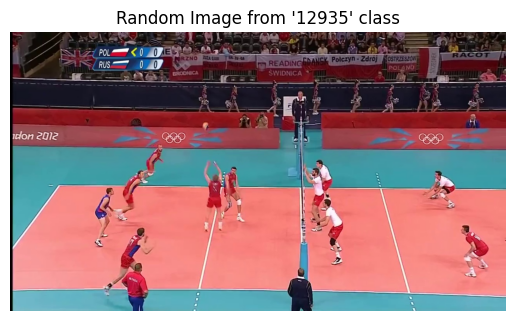

In [75]:
plot_random_image_from_dir(valid_split)

In [ ]:
plot_random_image_from_dir(test_split)

In [78]:
def plot_random_images(data, n=1):


    image_path_list = get_list_of_files(data)
    random_images = random.sample(image_path_list, n)
    fig, axes = plt.subplots(1, n, figsize=(n * 5, 5))  

    if n == 1:
        axes = [axes]  # If only 1 image, make sure axes is iterable

    for i, image_path in enumerate(random_images):
        img = Image.open(os.path.join('../..', image_path))
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis("off")

    plt.suptitle(f"Random Images from '{category}' class", fontsize=16)
    plt.show()

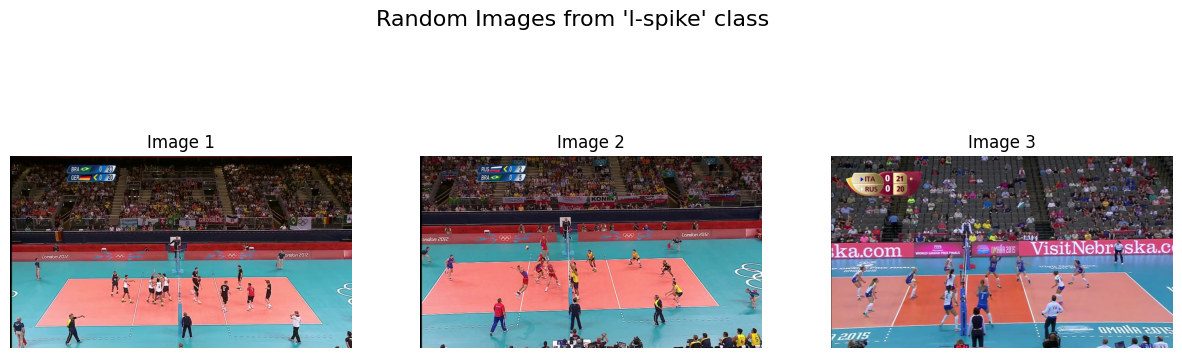

In [79]:
plot_random_images(train_split, 3)

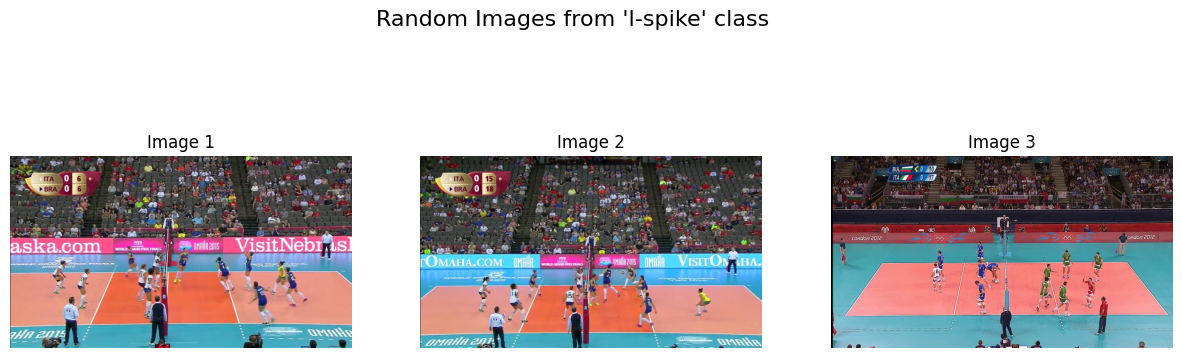

In [80]:
plot_random_images(valid_split, 3)

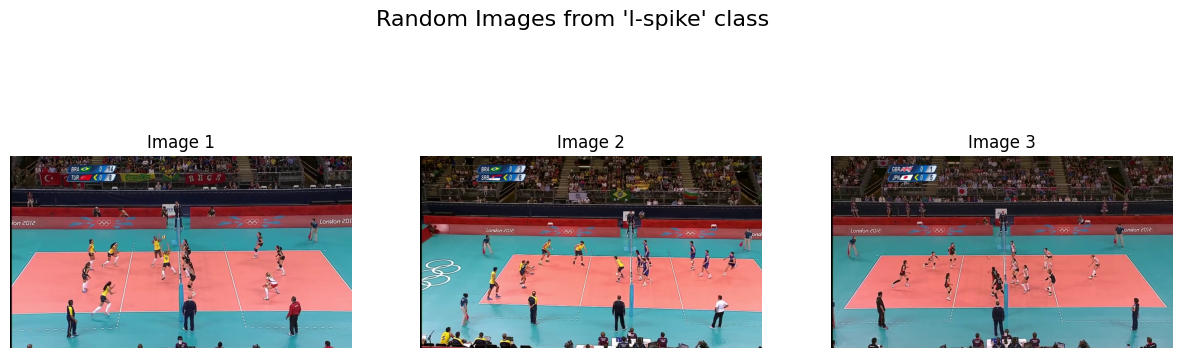

In [81]:
plot_random_images(test_split, 3)

In [142]:
class DatasetSplitter:
    def __init__(self, train_ratio=0.6, valid_ratio=0.1):
        self.annotation_root = os.path.join('../..', Paths.ANNOT_PKL.value)
        self.train_ratio = train_ratio
        self.valid_ratio = valid_ratio
        # self.test_ratio = test_ratio

    def get_all_annotations(self):

        with open(os.path.join('../..', Paths.ANNOT_PKL.value), "rb") as f:
            videos_annot_dct = pickle.load(f)
        labels = set()
        all_annotations = []
        for video_id, clips in videos_annot_dct.items(): # each video

            for clip_id, clip_data in clips.items():     # each clip

                category = clip_data['category']
                labels.add(category)

                for frame_id, boxes in clip_data["frame_boxes_dct"].items():    # Frames
                    frame_path = f"{Paths.VIDEOS_ROOT.value}/{video_id}/{clip_id}/{frame_id}.jpg"
                    all_annotations.append(
                        {
                            "path": frame_path, 
                            "category": category
                        }
                    )
        return all_annotations, labels

    def split_dataset(self):
        all_data, labels = self.get_all_annotations()
        random.shuffle(all_data)

        n_total = len(all_data)
        n_train = int(n_total * self.train_ratio)
        n_valid = int(n_total * self.valid_ratio)

        train_split = all_data[:n_train]
        valid_split = all_data[n_train:n_train+n_valid]
        test_split = all_data[n_train+n_valid:]

        return train_split, valid_split, test_split, sorted(list(labels))

splitter = DatasetSplitter()
train_split, valid_split, test_split, labels = splitter.split_dataset()

len(data_annot), len(train_split), len(valid_split), len(test_split), len(labels), labels  # (43470, 26082, 4347, 13041, 8)

(43470,
 26082,
 4347,
 13041,
 8,
 ['l-pass',
  'l-spike',
  'l_set',
  'l_winpoint',
  'r-pass',
  'r_set',
  'r_spike',
  'r_winpoint'])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

In [86]:
data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [87]:
image_path_list = get_list_of_files(train_split)
random_image_path = random.choice(image_path_list)
img = Image.open(os.path.join('../..', random_image_path))
img_as_array = np.array(img)
print(f"Before Transform : {img_as_array.shape}") 
transformed_img = data_transform(img)
print(f"After Transform : {transformed_img.shape}")

Before Transform : (720, 1280, 3)
After Transform : torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


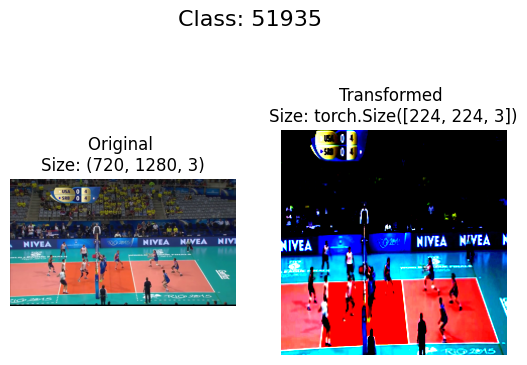

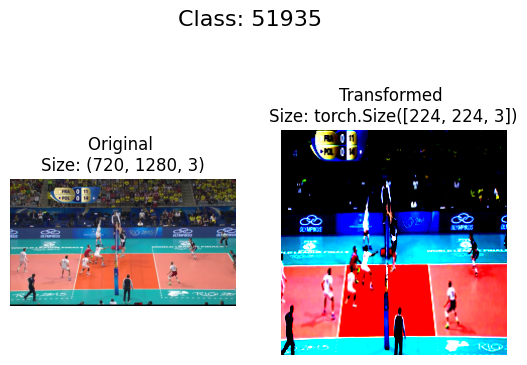

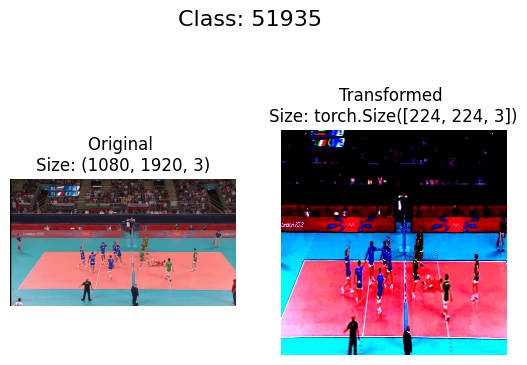

In [ ]:
def plot_transformed_images(image_paths_list, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths_list, k=n)
    for image_path in random_image_paths:
        with Image.open(os.path.join('../..', image_path)) as f:
            # img_as_array = np.asarray(f)
            # print(f"Image shape: {img_as_array.shape}")
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {np.asarray(f).shape}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            
# data_transform = transforms.Compose([
#             transforms.Resize((256, 256)),
#             transforms.CenterCrop((224, 224)),
#             transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ])

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)


In [137]:
class CustomDataset(Dataset):
    def __init__(self, data_split, labels, transform=None):
        """
        Args:
            data_split: list of dicts [{"path": ..., "category": ...}, ...]
            labels: full list of class labels
            transform: torchvision transforms
        """
        self.data_split = data_split
        self.labels = labels
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(labels)}
        self.transform = transform

    def __len__(self):
        return len(self.data_split)

    def __getitem__(self, idx):
        item = self.data_split[idx]
        # img = Image.open(item["path"]).convert("RGB")
        img = Image.open(os.path.join('../..', item["path"])).convert("RGB")
        label = self.class_to_idx[item["category"]]
        if self.transform:
            img = self.transform(img)
        return img, label


In [143]:
splitter = DatasetSplitter()
train_split, valid_split, test_split, labels = splitter.split_dataset()
print(labels)
print("transform")
train_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

test_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop((224, 224)),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

train_dataset = CustomDataset(train_split, labels, transform=train_transforms)
valid_dataset = CustomDataset(valid_split, labels, transform=test_transforms)
test_dataset  = CustomDataset(test_split,  labels, transform=test_transforms)


train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_dataloader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=4)


train_dataset , valid_dataset, test_dataset


['l-pass', 'l-spike', 'l_set', 'l_winpoint', 'r-pass', 'r_set', 'r_spike', 'r_winpoint']
transform


(<__main__.CustomDataset at 0x78b6561003a0>,
 <__main__.CustomDataset at 0x78b656102560>)

In [139]:
print(f"len train : {len(train_dataset)}")
print(f"len valid : {len(valid_dataset)}")
print(f"len test : {len(test_dataset)}")

len train : 26082
len valid : 4347
len test : 13041


In [144]:
print(valid_dataset.labels)
print(valid_dataset.class_to_idx)

['l-pass', 'l-spike', 'l_set', 'l_winpoint', 'r-pass', 'r_set', 'r_spike', 'r_winpoint']
{'l-pass': 0, 'l-spike': 1, 'l_set': 2, 'l_winpoint': 3, 'r-pass': 4, 'r_set': 5, 'r_spike': 6, 'r_winpoint': 7}


In [101]:
print(train_dataset[0]) 

(tensor([[[-1.0048, -0.9363, -1.2274,  ..., -1.0562, -1.3473, -1.2617],
         [-0.7479, -0.8164, -0.6794,  ..., -1.1247, -1.3302, -1.2445],
         [ 0.0227,  0.0741,  0.1254,  ..., -1.1247, -1.3130, -1.2274],
         ...,
         [ 1.0159, -0.0629,  1.1872,  ...,  1.2385, -0.0629,  0.9988],
         [ 0.2282,  0.4679,  1.4783,  ...,  1.6838,  0.1426,  0.3481],
         [-0.1143,  1.2385,  0.8447,  ...,  1.5297,  0.7248, -0.1999]],

        [[-1.0728, -0.9853, -1.2479,  ..., -0.9153, -1.2129, -1.1604],
         [-0.8102, -0.8102, -0.6176,  ..., -0.9503, -1.1954, -1.1779],
         [ 0.0126,  0.1527,  0.2227,  ..., -0.9678, -1.2129, -1.1954],
         ...,
         [ 1.8683,  0.8704,  1.9909,  ...,  1.7633,  0.6954,  1.8683],
         [ 1.1681,  1.3081,  2.2535,  ...,  2.2360,  0.9405,  1.2556],
         [ 0.8529,  1.9909,  1.8508,  ...,  2.2360,  1.6057,  0.8880]],

        [[-1.2990, -1.1073, -1.3861,  ..., -0.7064, -0.9504, -0.9678],
         [-1.4210, -1.4907, -1.3687,  ..., -

In [147]:
image, label = train_dataset[0]
class_names = train_dataset.labels
class_to_idx = train_dataset.class_to_idx

In [148]:
class_names

['l-pass',
 'l-spike',
 'l_set',
 'l_winpoint',
 'r-pass',
 'r_set',
 'r_spike',
 'r_winpoint']

In [149]:
class_to_idx

{'l-pass': 0,
 'l-spike': 1,
 'l_set': 2,
 'l_winpoint': 3,
 'r-pass': 4,
 'r_set': 5,
 'r_spike': 6,
 'r_winpoint': 7}

In [151]:
print(image.shape)
print(label)
print(class_names[label])

torch.Size([3, 224, 224])
2
l_set


In [122]:
import torch

In [123]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes,  #: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = 42):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    print(random_samples_idx)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[2472, 1617, 1308]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


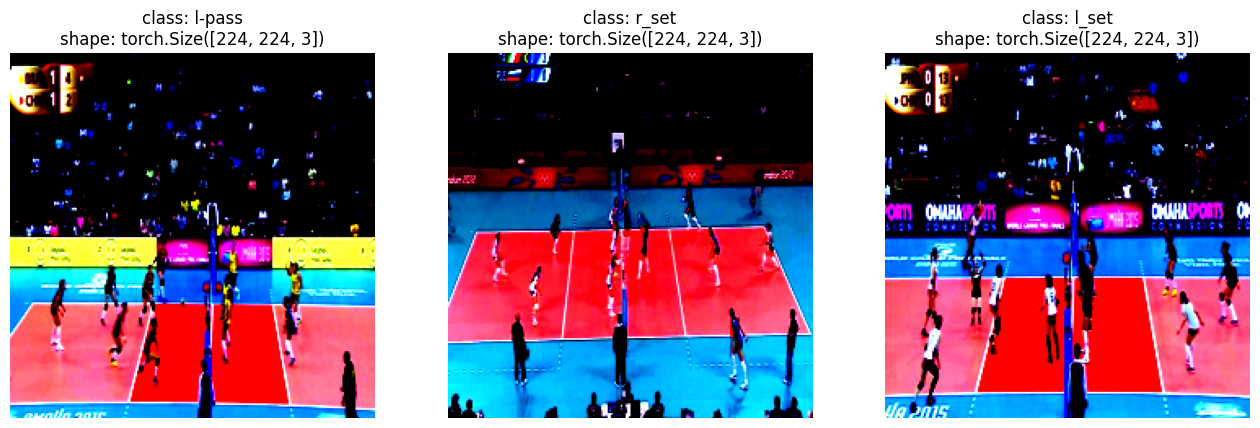

In [124]:
display_random_images(valid_dataset, 
                      n=3, 
                      classes=class_names,
                      seed=None)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[3454, 11035, 70]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


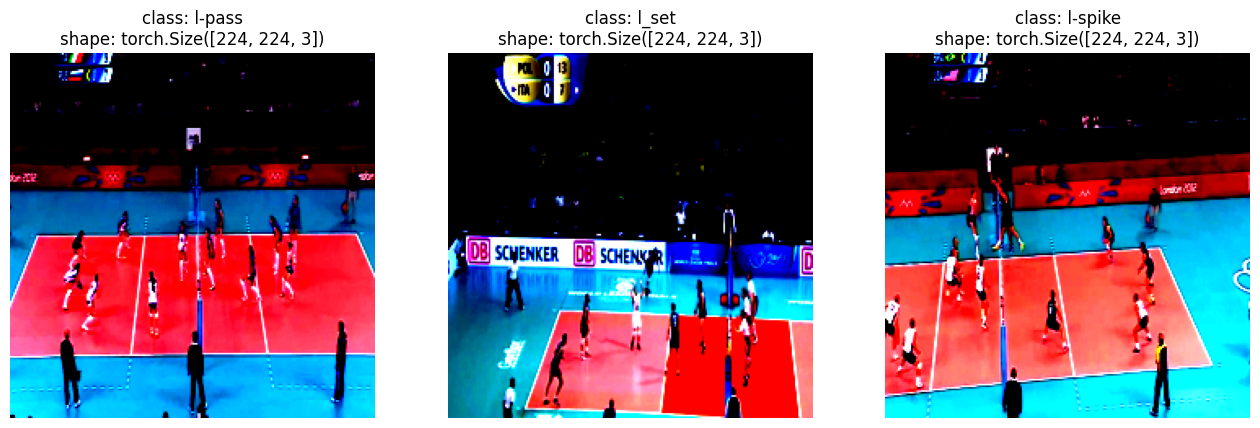

In [125]:
display_random_images(test_dataset, 
                      n=3, 
                      classes=class_names,
                      seed=None)

In [131]:
BATCH_SIZE = 32
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {train_dataloader.batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {test_dataloader.batch_size}")
print(f"Length of valid dataloader: {len(valid_dataloader)} batches of {valid_dataloader.batch_size}")


Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x78b536aafa60>, <torch.utils.data.dataloader.DataLoader object at 0x78b536aafa30>)
Length of train dataloader: 816 batches of 32
Length of test dataloader: 408 batches of 32
Length of valid dataloader: 136 batches of 32


In [132]:
print(train_dataloader.batch_size)
print(test_dataloader.dataset)

32


In [133]:
l=0
for i in train_dataloader:  # i(list of tensors) ==> [Batch([32, 1, 28, 28]), labels([32])]
    print("Batch",l+1)
    # print(type(i)) # List
    print("size of i:", len(i))              # Size = 2 List 
    print("shape of batch data: i[0] :", i[0].shape,"labels:i[1] :", i[1].shape) # Tensor, Tensor
    print("shape of first image in batch", i[0][0].shape)
    l+=1
    if (l==2):
        break

Batch 1
size of i: 2
shape of batch data: i[0] : torch.Size([32, 3, 224, 224]) labels:i[1] : torch.Size([32])
shape of first image in batch torch.Size([3, 224, 224])
Batch 2
size of i: 2
shape of batch data: i[0] : torch.Size([32, 3, 224, 224]) labels:i[1] : torch.Size([32])
shape of first image in batch torch.Size([3, 224, 224])


In [134]:
print("=========================")
for batch, i in enumerate (train_dataloader):  # c (Counter), i ==> [Batch([32, 1, 28, 28]), labels([32])]
    print("Batch", batch, "===> ", i[0].shape, i[1].shape)
    if batch == 5:
        break

Batch 0 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 1 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 2 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 3 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 4 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])
Batch 5 ===>  torch.Size([32, 3, 224, 224]) torch.Size([32])


In [135]:
for batch, (images, labels) in enumerate(train_dataloader):
    print(f"Batch {batch + 1}:")  
    print(f"  Batch Images shape: {images.shape}")   # [32, 1, 28, 28]
    print(f"  Batch Labels shape: {labels.shape}")   # [32]
    
    print(f"  Single Images: {images[0].shape}")
    print(f"  Single Label: {labels[0].item()}")
    print(f"  Label: {class_names[labels[0].item()]}")
    break 

Batch 1:
  Batch Images shape: torch.Size([32, 3, 224, 224])
  Batch Labels shape: torch.Size([32])
  Single Images: torch.Size([3, 224, 224])
  Single Label: 4
  Label: r_spike


In [136]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## Model

In [161]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
from torchinfo  import summary

In [159]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

In [163]:
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

In [164]:
resnet50

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [162]:
summary(model, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1000]                --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│ 

In [176]:
resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [166]:
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total, trainable = count_params(resnet50)
print(f"\nTotal parameters: {total:,}")
print(f"Trainable parameters: {trainable:,}")


Total parameters: 25,557,032
Trainable parameters: 25,557,032


In [171]:
resnet50_param_cpy = list(resnet50.parameters())

for param in resnet50_param_cpy:
    print(param.shape)
    print("Before:", param.requires_grad)
    param.requires_grad = False
    print("After :", param.requires_grad)
    break

torch.Size([64, 3, 7, 7])
Before: True
After : False


In [179]:
in_features = resnet50.fc.in_features
print("===================================")
resnet50.fc = nn.Linear(in_features, num_classes)
print(f" Final layer replaced: {in_features} → {num_classes}")
print(resnet50.fc)

 Final layer replaced: 2048 → 8
Linear(in_features=2048, out_features=8, bias=True)


In [180]:
dummy_input = torch.randn(1, 3, 224, 224)
out = model(dummy_input)
print("\nForward pass output shape:", out.shape)


Forward pass output shape: torch.Size([1, 8])


In [167]:
class ResNet50Finetuner(nn.Module):
    def __init__(self, num_classes: int, freeze_backbone: bool = True, lr: float = 1e-3, device=None):
        """
        Fine-tuned ResNet50 model.

        Args:
            num_classes (int): number of classes in your dataset.
            freeze_backbone (bool): if True, freeze feature extractor and only train FC head.
            lr (float): learning rate for optimizer.
        """
        super().__init__()

        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load pretrained ResNet50
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        print("  Loaded pretrained ResNet50 (ImageNet weights)")

        # Freeze backbone if required
        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False
            print("   Backbone frozen (only final FC will train)")
        else:
            print("   All layers are trainable")

        # Replace final layer
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)
        print(f"   Final layer replaced: {in_features} → {num_classes}")

        # Training components
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

        self.model.to(self.device)

    def forward(self, x):
        return self.model(x)

    def explore(self, input_size=(1, 3, 224, 224)):
        """
        Print model summary and param counts.
        """
        print("\n--- Model Summary ---\n")
        summary(self.model, input_size=input_size)

        total = sum(p.numel() for p in self.model.parameters())
        trainable = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"\n   Total parameters: {total:,}")
        print(f"     Trainable parameters: {trainable:,}")

    def train_model(self, train_loader, valid_loader=None, epochs=5, print_every=50):
        """
        Train the model with optional validation.

        Args:
            train_loader: DataLoader for training data
            valid_loader: DataLoader for validation data
            epochs (int): number of training epochs
            print_every (int): print loss every n batches
        """
        for epoch in range(1, epochs + 1):
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0

            loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}/{epochs}")
            for i, (inputs, labels) in loop:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                if (i + 1) % print_every == 0:
                    loop.set_postfix(loss=running_loss / (i + 1), acc=correct / total)

            epoch_loss = running_loss / len(train_loader)
            epoch_acc = correct / total
            print(f"\nEpoch {epoch} → Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

            if valid_loader:
                self.evaluate(valid_loader)

    def evaluate(self, loader):
        """
        Evaluate the model on a dataset.
        """
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        acc = correct / total
        print(f"Validation Accuracy: {acc:.4f}")
        return acc
    



In [168]:

num_classes = 8  
model = ResNet50Finetuner(num_classes=num_classes, freeze_backbone=True)
model.explore(input_size=(1, 3, 224, 224))

# Test forward pass
dummy_input = torch.randn(1, 3, 224, 224)
out = model(dummy_input)
print("\nForward pass output shape:", out.shape)  # should be [1, num_classes]

Loaded pretrained ResNet50 (ImageNet weights)
Backbone frozen (only final FC will train)
 Final layer replaced: 2048 → 8

--- Model Summary ---


   Total parameters: 23,524,424
     Trainable parameters: 16,392

Forward pass output shape: torch.Size([1, 8])


In [ ]:
# Initialize model for 8 classes
num_classes = 8
model = ResNet50Finetuner(num_classes=num_classes, freeze_backbone=True, lr=1e-3)

# Explore model
model.explore(input_size=(1, 3, 224, 224))

# Train the model
model.train_model(train_loader=train_dataloader, 
                  valid_loader=valid_dataloader, 
                  epochs=5, 
                  print_every=20)

# Evaluate on test set
model.evaluate(test_dataloader)
